In [ ]:
!wget --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5144/862050/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1619029562&Signature=M49cJanl0LkP6yuD1jvh3v784em9BZakCaGhKV0Bh8lZeypQ0zCp39YWEtbtor0G8WLtlElGrHU1XfSQviLSn4Y37gGIbdZy1VRTmf%2Bew%2B00mJY0h8f%2Bw%2BfW6nWL9huOmm9k%2BTviI2zjMdzWihynHZhlrIFgftW3M4vHWmi%2FtHtT5s328ZMLGlCE9EWanz8ysABbrPt8oa4B0j2BH5QdvUWKrHKSXvgw1MHuCfD%2F0u7eU9ig1AOYD9HXfexdsRzPt84p4WqOqHMOLVgxrU3b3KICQn28u8Bv%2BGVw1fyM%2BO0IWiaY0FGvOptdCZrm%2BQYQ0ZRh88pKGEdpzFN6X9eK7w%3D%3D&response-content-disposition=attachment%3B+filename%3Dultrasound-nerve-segmentation.zip' --output-document 'ultrasound-nerve-segmentation.zip'
!pip install q keras==2.4.1
!pip install segmentation_models
!pip install tensorflow_io
!unzip '/content/ultrasound-nerve-segmentation.zip'

In [2]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
import tensorflow_io as tfio
import keras
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate,Dropout
from tensorflow.keras.layers import Multiply, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow
import keras
import cv2
import imgaug.augmenters as iaa
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
focal_loss = sm.losses.cce_dice_loss
import random
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
#loading the dataframe containing images after removing conflicting images
df=pd.read_csv('/content/train_masks.csv')
img=pd.read_csv('/content/drive/MyDrive/dup_rem.csv')
img.drop('Unnamed: 0',axis=1,inplace=True)
img.image_name=img.image_name.astype(int)
img.subject_name=img.subject_name.astype(int)
img.columns=['image_path','img','subject','mask_path']
new_df=pd.merge(img,df,on=['img','subject'])
new_df.pixels.fillna(0,inplace=True)
val=[0 if i==0 else 1 for i in new_df.pixels]
new_df['mask_pres']=val

In [59]:
def cnn_generator(images, labels, is_training, batch_size=64):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename,labels):
        #reading path 
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tfio.experimental.image.decode_tiff(image_string)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        
        image = tf.image.resize(image, [im_height, im_width])
        return image,labels
    
    def flip_lr(image,labels):
        
        image = tf.image.flip_left_right(image)
        
        return image,labels
    def flip_ud(image,labels):
        
        image = tf.image.flip_up_down(image)
        
        return image,labels    
    
    def rotate(image,labels):
        val=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        return tf.image.rot90(image, val),labels
    
    
    dataset = tf.data.Dataset.from_tensor_slices((images,labels))
    
    if is_training:
        dataset = dataset.shuffle(5000)  # depends on sample size
        
    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size,num_parallel_batches=4,  # cpu cores
        drop_remainder=True if is_training else False))
    # augmentations = [flip,rotate]
    
    if is_training:   
      if np.random.uniform(0,1)<0.1:
          dataset = dataset.map(flip_lr)
      elif np.random.uniform(0,1)<0.2:
          dataset = dataset.map(flip_ud)
      elif np.random.uniform(0,1)<0.3:        
          dataset = dataset.map(rotate)
    dataset = dataset.repeat()
    
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(new_df.image_path, new_df.mask_pres, test_size=0.2, random_state=42)

In [61]:
im_height=128
im_width=128
tf.keras.backend.clear_session()
tr_cnn_generator = cnn_generator(X_train,y_train, is_training=True, batch_size=64)
val_cnn_generator = cnn_generator(X_valid,y_valid, is_training=False, batch_size=64)

In [62]:
#using a pretrained network
base_model = keras.applications.InceptionResNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False)

In [44]:
base_model.trainable = False

In [63]:
inp=Input((128,128,4))
conv1=Conv2D(filters=3,kernel_size=(3,3),padding='same')(inp)
base_model=base_model(conv1,training=False)
out = Flatten()(base_model)
out = Dense(1024, activation="relu")(out)
out = Dropout(0.5)(out)
out = Dense(1, activation="sigmoid")(out)

In [64]:
model_clf = Model(inputs = inp, outputs = out)

In [101]:
from datetime import datetime
# logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True,write_grads=True)
callbacks = [
    ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=False)
    ]
model_clf.compile(optimizer=Adam(lr=1e-8), loss='binary_crossentropy', metrics=['accuracy','AUC'])

In [54]:
model_clf.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 4)]     0         
_________________________________________________________________
conv2d_407 (Conv2D)          (None, 128, 128, 3)       111       
_________________________________________________________________
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              6292480   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025

In [ ]:
result_clf=model_clf.fit(tr_cnn_generator,steps_per_epoch=64,epochs=30,validation_data=val_cnn_generator,validation_steps=64,callbacks=callbacks,initial_epoch=0)

Epoch 1/30
64/64 [==============================] - 64s 809ms/step - loss: 6.1494 - accuracy: 0.5266 - auc: 0.5153 - val_loss: 0.6346 - val_accuracy: 0.5958 - val_auc: 0.6949

Epoch 00001: val_loss improved from inf to 0.63464, saving model to best_model.h5
Epoch 2/30
64/64 [==============================] - 54s 852ms/step - loss: 0.6686 - accuracy: 0.5907 - auc: 0.6117 - val_loss: 0.6236 - val_accuracy: 0.6616 - val_auc: 0.7080

Epoch 00002: val_loss improved from 0.63464 to 0.62360, saving model to best_model.h5
Epoch 3/30
64/64 [==============================] - 55s 875ms/step - loss: 0.6273 - accuracy: 0.6468 - auc: 0.6938 - val_loss: 0.6069 - val_accuracy: 0.6830 - val_auc: 0.7301

Epoch 00003: val_loss improved from 0.62360 to 0.60689, saving model to best_model.h5
Epoch 4/30
64/64 [==============================] - 57s 888ms/step - loss: 0.6188 - accuracy: 0.6562 - auc: 0.7101 - val_loss: 0.5891 - val_accuracy: 0.6849 - val_auc: 0.7469

Epoch 00004: val_loss improved from 0.6068

In [109]:
model_clf.load_weights('best_model.h5')

In [99]:
def classifier_generator(images):
    '''Data generator for inference phase'''
    image_string=tf.io.read_file(images)
    image = tfio.experimental.image.decode_tiff(image_string)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image

Prediction

In [73]:
#generating predictions on train and validation set
X_tr=np.zeros((len(X_train),128,128,4))
X_val=np.zeros((len(X_valid),128,128,4))
for i in range(len(X_train)):
  X_tr[i]=classifier_generator(X_train.iloc[i])
for i in range(len(X_valid)):
  X_val[i]=classifier_generator(X_valid.iloc[i])  
pred_clf_tr=model_clf.predict(X_tr)
pred_clf_val=model_clf.predict(X_val)

In [106]:
#using a default thresold of 0.5 for prediction
pred_clf_val=(np.array(pred_clf_val)>0.5)
pred_clf_tr=(np.array(pred_clf_tr)>0.5)

In [90]:
def Heatmapgen(x):
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea referred from here
  group_names = ['True -ve','False +ve','False -ve','True +ve']
  group_counts = ['{0:0.0f}'.format(value) for value in x.flatten()]
  labels = [f'{v1}\n{v2}' for v1, v2 in
  zip(group_names,group_counts)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(x, annot=labels, fmt='', cmap='RdBu')

Getting number of false positives and false negatives

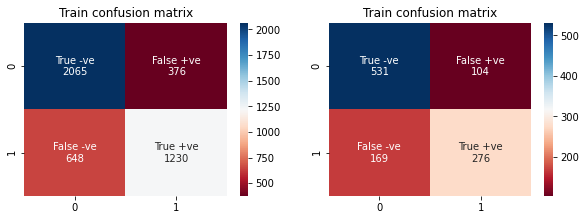

In [ ]:
#generating the confusion matrix
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(221)
cf_matr1=confusion_matrix(y_train,pred_clf_tr_)
plt.title('Train confusion matrix')
Heatmapgen(cf_matr1)
ax2 = fig.add_subplot(222)
cf_matr2=confusion_matrix(y_valid,pred_clf_val_)
plt.title('Validation confusion matrix')
Heatmapgen(cf_matr2)

In [75]:
#storing the predictions in a list
pred_clf_val=[i[0] for i in pred_clf_val]
pred_clf_tr=[i[0] for i in pred_clf_tr]

Oversampling misclassified points

In [76]:
#getting the misclassified data points
wrng_pred=np.where(pred_clf_tr!=y_train,1,0)
#getting the indices..
wrng_pred=np.argwhere(wrng_pred)
wrng_pred=[i[0] for i in wrng_pred]
#out of misclassified datapoints randomly sampling 500 data points
smpl=random.sample(wrng_pred,500)
X_tr_smp=X_train.iloc[smpl]
y_tr_smp=y_train.iloc[smpl]
#oversampling the train set with misclassified datapoints
X_train_new=X_train.append(X_tr_smp)
y_train_new=y_train.append(y_tr_smp)

In [77]:
im_height=128
im_width=128
tf.keras.backend.clear_session()
tr_cnn_generator = cnn_generator(X_train_new,y_train_new, is_training=True, batch_size=64)
val_cnn_generator = cnn_generator(X_valid,y_valid, is_training=False, batch_size=64)

Retraining the model on oversampled points

In [110]:
#retraining the model with oversampled data
result_clf=model_clf.fit(tr_cnn_generator,steps_per_epoch=64,epochs=20,validation_data=val_cnn_generator,validation_steps=64,callbacks=callbacks,initial_epoch=10)

Epoch 11/20
64/64 [==============================] - 45s 690ms/step - loss: 0.4203 - accuracy: 0.7974 - auc: 0.8858 - val_loss: 0.4827 - val_accuracy: 0.7736 - val_auc: 0.8483

Epoch 00011: val_loss improved from inf to 0.48270, saving model to best_model.h5
Epoch 12/20
64/64 [==============================] - 44s 684ms/step - loss: 0.4264 - accuracy: 0.7917 - auc: 0.8829 - val_loss: 0.4828 - val_accuracy: 0.7726 - val_auc: 0.8485

Epoch 00012: val_loss did not improve from 0.48270
Epoch 13/20
64/64 [==============================] - 43s 676ms/step - loss: 0.4269 - accuracy: 0.7896 - auc: 0.8807 - val_loss: 0.4828 - val_accuracy: 0.7716 - val_auc: 0.8485

Epoch 00013: val_loss did not improve from 0.48270
Epoch 14/20
64/64 [==============================] - 43s 679ms/step - loss: 0.4263 - accuracy: 0.7893 - auc: 0.8825 - val_loss: 0.4828 - val_accuracy: 0.7716 - val_auc: 0.8486

Epoch 00014: val_loss did not improve from 0.48270
Epoch 15/20
64/64 [==============================] - 43s 

In [103]:
#getting predictions using new model
X_tr=np.zeros((len(X_train),128,128,4))
X_val=np.zeros((len(X_valid),128,128,4))
for i in range(len(X_train)):
  X_tr[i]=classifier_generator(X_train.iloc[i])
for i in range(len(X_valid)):
  X_val[i]=classifier_generator(X_valid.iloc[i])  
pred_clf_tr=model_clf.predict(X_tr)
pred_clf_val=model_clf.predict(X_val)

In [104]:
#finding the best threshold on the newly trained model
#for this we calculate both the false positives and false negatives in the predictions
fp_arr_tr=[]
fn_arr_tr=[]
fp_arr_val=[]
fn_arr_val=[]
thresholds=[0.3,0.35,0.4,0.45,0.5,0.55,0.6]
for i in thresholds:
  pred_clf_val_=(np.array(pred_clf_val)>i)
  pred_clf_tr_=(np.array(pred_clf_tr)>i)
  cf_matr1=confusion_matrix(y_train,pred_clf_tr_)
  cf_matr2=confusion_matrix(y_valid,pred_clf_val_)
  fp_arr_tr.append(cf_matr1[0][1])
  fn_arr_tr.append(cf_matr1[1][0])
  fp_arr_val.append(cf_matr2[0][1])
  fn_arr_val.append(cf_matr2[1][0])


Trying various thresholds

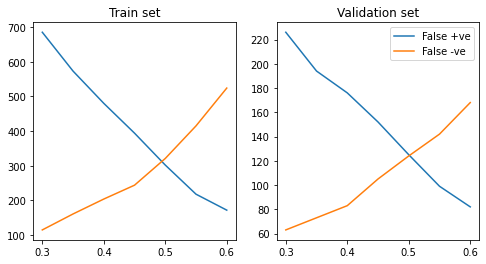

In [108]:
#plotting the fp and fn in train and validation set
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].set_title('Train set')
ax[0].plot(thresholds,fp_arr_tr,label='False +ve')
ax[0].plot(thresholds,fn_arr_tr,label='False -ve')
ax[1].set_title('Validation set')
ax[1].plot(thresholds,fp_arr_val,label='False +ve')
ax[1].plot(thresholds,fn_arr_val,label='False -ve')
plt.legend()
plt.show()

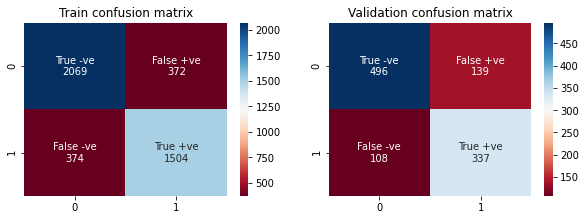

In [91]:
#0.5
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(221)
cf_matr1=confusion_matrix(y_train,pred_clf_tr)
plt.title('Train confusion matrix')
Heatmapgen(cf_matr1)
ax2 = fig.add_subplot(222)
cf_matr2=confusion_matrix(y_valid,pred_clf_val)
plt.title('Validation confusion matrix')
Heatmapgen(cf_matr2)

At threshold of 0.5 both fp and fn were together miniimum..